In [15]:
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
import matplotlib.ticker as mticker
plt.rcParams['figure.facecolor'] = 'white'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
def prepro(ds):
    return ds.isel(y=slice(400, None))

In [3]:
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]

In [5]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)

In [6]:
KE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-KE" 
                                + "/clim/CREG12.L75-REF08_*.5d_KEclim.nc"))
KE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-KE" 
                                + "/clim/CREG12.L75-FUT08_*.5d_KEclim.nc"))
ICE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-icemod_clim/" 
                                + "/CREG12.L75-REF08_*.5d_icemodclim.nc"))
ICE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-icemod_clim/" 
                                + "/CREG12.L75-FUT08_*.5d_icemodclim.nc"))

In [7]:
KEREF = xr.open_mfdataset(KE_data_filesREF, parallel=True, preprocess=prepro)
KEFUT = xr.open_mfdataset(KE_data_filesFUT, parallel=True, preprocess=prepro)
ICEREF = xr.open_mfdataset(ICE_data_filesREF, parallel=True, preprocess=prepro)
ICEFUT = xr.open_mfdataset(ICE_data_filesFUT, parallel=True, preprocess=prepro)

In [8]:
KEREF = KEREF.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})
KEFUT = KEFUT.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})

In [9]:
KEREFplot = KEREF.voke.isel(deptht=0).mean("time_counter").compute()
KEFUTplot = KEFUT.voke.isel(deptht=0).mean("time_counter").compute()

In [10]:
KEREFplotD1 = KEREF.voke.sel(deptht=100, method="nearest").mean("time_counter").compute()
KEFUTplotD1 = KEFUT.voke.sel(deptht=100, method="nearest").mean("time_counter").compute()

In [ ]:
KEREFplotD2 = KEREF.voke.sel(deptht=300, method="nearest").mean("time_counter").compute()
KEFUTplotD2 = KEFUT.voke.sel(deptht=300, method="nearest").mean("time_counter").compute()

In [11]:
ICEREFplot = ICEREF.siconc.mean("time_counter").compute()
ICEREFplot[1277, 754:756] = np.nan # need to remove a few points for contour plot in projection
ICEFUTplot = ICEFUT.siconc.mean("time_counter").compute()

In [25]:
def map_config(ax):
    ax.set_extent([-180, 180, 67, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="silver")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, y_inline=True,
                     linewidth=1, color='gray', alpha=0.7, linestyle='--')
    b11 = bathyplot.plot.contour(x='nav_lon', y='nav_lat', levels=[1500], 
                             colors=["snow"], linewidths=1, alpha=0.8, linestyles="-", 
                             ax=ax, transform=ccrs.PlateCarree(), zorder=2)
    b12 = bathyplot.plot.contour(x='nav_lon', y='nav_lat', levels=[1500], 
                             colors=["dimgray"], linewidths=0.5, linestyles="-", 
                             ax=ax, transform=ccrs.PlateCarree(), alpha=0.8, zorder=3)
    plt.draw()
    return

In [13]:
proj = ccrs.RotatedPole(pole_longitude=180, pole_latitude=40, central_rotated_longitude=0)

In [ ]:
bathy = grid.gdept_1d.squeeze().isel(z=grid.mbathy.squeeze().compute())
bathy = bathy.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat}).compute()

In [ ]:
bathyplot = xr.where(bathy > 500, bathy, np.nan)
# need to set some points to NaN to avoid problems with the contour plot
bathyplot[1118:1165, 775:787] = np.nan # 1500
bathyplot[878:881, 849:851] = np.nan # 1500

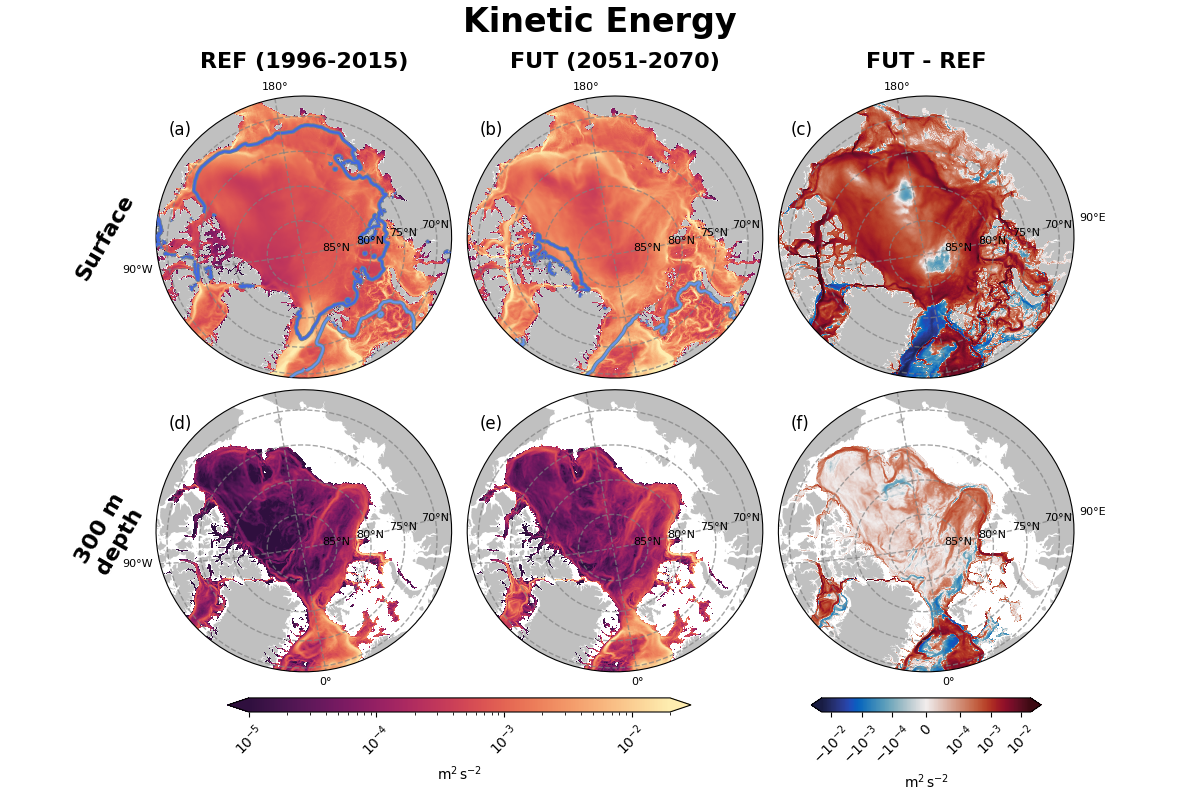

In [30]:
fig = plt.figure(figsize=(10, 100/12))
gs = fig.add_gridspec(5, 24, height_ratios=[1, 1, 1, 0.001, 0.07])

ax1 = fig.add_subplot(gs[0, 0:8], projection=proj)
ax2 = fig.add_subplot(gs[0, 8:16], projection=proj)
ax3 = fig.add_subplot(gs[0, 16:24], projection=proj)
ax4 = fig.add_subplot(gs[1, 0:8], projection=proj)
ax5 = fig.add_subplot(gs[1, 8:16], projection=proj)
ax6 = fig.add_subplot(gs[1, 16:24], projection=proj)
ax7 = fig.add_subplot(gs[2, 0:8], projection=proj)
ax8 = fig.add_subplot(gs[2, 8:16], projection=proj)
ax9 = fig.add_subplot(gs[2, 16:24], projection=proj)
axcb1 = fig.add_subplot(gs[4, 2:14])
axcb2 = fig.add_subplot(gs[4, 17:23])

p1 = KEREFplot.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                    norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                    ax=ax1, transform=ccrs.PlateCarree(), rasterized=True, 
                    zorder=1, add_colorbar=False)
i11 = ICEREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["slategrey", "slategrey"], linewidths=3,
                              ax=ax1, transform=ccrs.PlateCarree(), zorder=2)
i12 = ICEREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["limegreen", "royalblue"], linewidths=2, 
                              ax=ax1, transform=ccrs.PlateCarree(), zorder=3)

p2 = KEFUTplot.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                    norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                    ax=ax2, transform=ccrs.PlateCarree(), rasterized=True, 
                    zorder=1, add_colorbar=False)
i21 = ICEFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["slategrey", "slategrey"], linewidths=3, 
                              ax=ax2, transform=ccrs.PlateCarree(), zorder=2)
i22 = ICEFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["limegreen", "royalblue"], linewidths=2, 
                              ax=ax2, transform=ccrs.PlateCarree(), zorder=2)

p3 = (KEFUTplot - KEREFplot).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                  norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                         vmin=-2e-2, vmax=2e-2),
                                  ax=ax3, transform=ccrs.PlateCarree(), rasterized=True, 
                                  zorder=1, add_colorbar=False)

p4 = KEREFplotD1.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax4, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p5 = KEFUTplotD1.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax5, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p6 = (KEFUTplotD1 - KEREFplotD1).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                    norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                           vmin=-2e-2, vmax=2e-2),
                                    ax=ax6, transform=ccrs.PlateCarree(), rasterized=True, 
                                    zorder=1, add_colorbar=False)

p7 = KEREFplotD2.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax7, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p8 = KEFUTplotD2.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax8, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p9 = (KEFUTplotD2 - KEREFplotD2).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                    norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                           vmin=-2e-2, vmax=2e-2),
                                    ax=ax9, transform=ccrs.PlateCarree(), rasterized=True, 
                                    zorder=1, add_colorbar=False)

fig.text(0.5, 0.96, "Kinetic Energy", fontsize=24, fontweight="bold", ha="center")

ax1.text(-90, 57, "Surface", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())
ax4.text(-90, 57, "100 m\ndepth", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())
ax7.text(-90, 57, "300 m\ndepth", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())

[ax.text(-143, 65, t, fontsize=12, transform=ccrs.PlateCarree(), backgroundcolor="whitesmoke") 
 for ax, t in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], 
                  ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"])]

gl = [map_config(ax) for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]];


for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.text(-30, 85, r"85$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-31, 80, r"80$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-34, 75, r"75$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-37, 70, r"70$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-41, 65, r"65$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    

cb1 = plt.colorbar(p1, cax=axcb1, orientation="horizontal", extend="both")
axcb1.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
axcb1.set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"], rotation=45, ha='center')
axcb1.tick_params(axis='x', which='major', pad=5)
axcb1.set_xlabel(r"m$^{2}\,$s$^{-2}$")
cb2 = plt.colorbar(p3, cax=axcb2, orientation="horizontal", extend="both")
axcb2.set_xticks([-1e-2, -1e-3, -1e-4, 0, 1e-4, 1e-3, 1e-2])
axcb2.set_xticklabels([r"$-10^{-2}$", r"$-10^{-3}$", r"$-10^{-4}$", 
                       r"$0$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"], rotation=45, ha='center')
axcb2.tick_params(axis='x', which='major', pad=5)
axcb2.set_xlabel(r"m$^{2}\,$s$^{-2}$")

[ax.set_title("") for ax in [ax4, ax7, ax5, ax6, ax8, ax9]]
ax1.set_title("REF\n(1996-2015)", fontsize=16, fontweight="bold", pad=5)
ax2.set_title("FUT\n(2051-2070)", fontsize=16, fontweight="bold", pad=5)
ax3.set_title("FUT - REF", fontsize=16, fontweight="bold", pad=5)

plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.07)

plt.savefig("figures/Figure_1_KE_ice.png", dpi=600)

In [ ]:
MKE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-MKE" 
                                + "/clim/CREG12.L75-REF08_*.5d_MKEclim.nc"))
MKE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-MKE" 
                                + "/clim/CREG12.L75-FUT08_*.5d_MKEclim.nc"))

In [ ]:
MKEREF = xr.open_mfdataset(MKE_data_filesREF, parallel=True, preprocess=prepro)
MKEFUT = xr.open_mfdataset(MKE_data_filesFUT, parallel=True, preprocess=prepro)

In [ ]:
MKEREF = MKEREF.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})
MKEFUT = MKEFUT.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})
MKEREFplot = MKEREF.vomke.isel(deptht=0).mean("time_counter").compute()
MKEFUTplot = MKEFUT.vomke.isel(deptht=0).mean("time_counter").compute()
MKEREFplotD1 = MKEREF.vomke.sel(deptht=100, method="nearest").mean("time_counter").compute()
MKEFUTplotD1 = MKEFUT.vomke.sel(deptht=100, method="nearest").mean("time_counter").compute()
MKEREFplotD2 = MKEREF.vomke.sel(deptht=300, method="nearest").mean("time_counter").compute()
MKEFUTplotD2 = MKEFUT.vomke.sel(deptht=300, method="nearest").mean("time_counter").compute()

In [ ]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(5, 24, height_ratios=[1, 1, 1, 0.001, 0.07])

ax1 = fig.add_subplot(gs[0, 0:8], projection=proj)
ax2 = fig.add_subplot(gs[0, 8:16], projection=proj)
ax3 = fig.add_subplot(gs[0, 16:24], projection=proj)
ax4 = fig.add_subplot(gs[1, 0:8], projection=proj)
ax5 = fig.add_subplot(gs[1, 8:16], projection=proj)
ax6 = fig.add_subplot(gs[1, 16:24], projection=proj)
ax7 = fig.add_subplot(gs[2, 0:8], projection=proj)
ax8 = fig.add_subplot(gs[2, 8:16], projection=proj)
ax9 = fig.add_subplot(gs[2, 16:24], projection=proj)
axcb1 = fig.add_subplot(gs[4, 2:14])
axcb2 = fig.add_subplot(gs[4, 17:23])

p1 = MKEREFplot.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                    norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                    ax=ax1, transform=ccrs.PlateCarree(), rasterized=True, 
                    zorder=1, add_colorbar=False)
i11 = ICEREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["slategrey", "slategrey"], linewidths=3,
                              ax=ax1, transform=ccrs.PlateCarree(), zorder=2)
i12 = ICEREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["cornflowerblue", "royalblue"], 
                              ax=ax1, transform=ccrs.PlateCarree(), zorder=3)

p2 = MKEFUTplot.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                    norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                    ax=ax2, transform=ccrs.PlateCarree(), rasterized=True, 
                    zorder=1, add_colorbar=False)
i21 = ICEFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["slategrey", "slategrey"], linewidths=3, 
                              ax=ax2, transform=ccrs.PlateCarree(), zorder=2)
i22 = ICEFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[0.15, 0.8], 
                              colors=["cornflowerblue", "royalblue"], 
                              ax=ax2, transform=ccrs.PlateCarree(), zorder=2)

p3 = (MKEFUTplot - MKEREFplot).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                  norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                         vmin=-2e-2, vmax=2e-2),
                                  ax=ax3, transform=ccrs.PlateCarree(), rasterized=True, 
                                  zorder=1, add_colorbar=False)

p4 = MKEREFplotD1.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax4, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p5 = MKEFUTplotD1.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax5, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p6 = (MKEFUTplotD1 - MKEREFplotD1).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                    norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                           vmin=-2e-2, vmax=2e-2),
                                    ax=ax6, transform=ccrs.PlateCarree(), rasterized=True, 
                                    zorder=1, add_colorbar=False)

p7 = MKEREFplotD2.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax7, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p8 = MKEFUTplotD2.plot(x='nav_lon', y='nav_lat', cmap=cmo.matter_r, 
                     norm=colors.LogNorm(vmin=1e-5, vmax=2e-2),
                     ax=ax8, transform=ccrs.PlateCarree(), rasterized=True, 
                     zorder=1, add_colorbar=False)

p9 = (MKEFUTplotD2 - MKEREFplotD2).plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                                    norm=colors.SymLogNorm(linthresh=1e-4, linscale=1, 
                                                           vmin=-2e-2, vmax=2e-2),
                                    ax=ax9, transform=ccrs.PlateCarree(), rasterized=True, 
                                    zorder=1, add_colorbar=False)

fig.text(0.5, 0.96, "Mean Kinetic Energy", fontsize=24, fontweight="bold", ha="center")

ax1.set_title("REF\n(1996-2015)", fontsize=16, fontweight="bold", pad=10)
ax2.set_title("FUT\n(2051-2070)", fontsize=16, fontweight="bold", pad=10)
ax3.set_title("FUT - REF", fontsize=16, fontweight="bold", pad=10)
[ax.set_title("") for ax in [ax4, ax7, ax5, ax6, ax8, ax9]]

ax1.text(-90, 57, "Surface", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())
ax4.text(-90, 57, "100 m\ndepth", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())
ax7.text(-90, 57, "300 m\ndepth", fontsize=16, fontweight="bold", ha="center", rotation=60, transform=ccrs.PlateCarree())

[ax.text(-143, 65, t, fontsize=12, transform=ccrs.PlateCarree(), backgroundcolor="whitesmoke") 
 for ax, t in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], 
                  ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"])]

gl = [map_config(ax) for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]];


for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.text(-30, 85, r"85$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-31, 80, r"80$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-34, 75, r"75$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-37, 70, r"70$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    ax.text(-41, 65, r"65$^{\circ}$N", transform=ccrs.PlateCarree(), ha="center", fontsize=7)
    

cb1 = plt.colorbar(p1, cax=axcb1, orientation="horizontal", extend="both")
axcb1.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
axcb1.set_xticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"], rotation=45, ha='center')
axcb1.tick_params(axis='x', which='major', pad=5)
axcb1.set_xlabel(r"m$^{2}\,$s$^{-2}$")
cb2 = plt.colorbar(p3, cax=axcb2, orientation="horizontal", extend="both")
axcb2.set_xticks([-1e-2, -1e-3, -1e-4, 0, 1e-4, 1e-3, 1e-2])
axcb2.set_xticklabels([r"$-10^{-2}$", r"$-10^{-3}$", r"$-10^{-4}$", 
                       r"$0$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"], rotation=45, ha='center')
axcb2.tick_params(axis='x', which='major', pad=5)
axcb2.set_xlabel(r"m$^{2}\,$s$^{-2}$")

plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.savefig("figures/Figure_S1_MKE_ice.png", dpi=600)